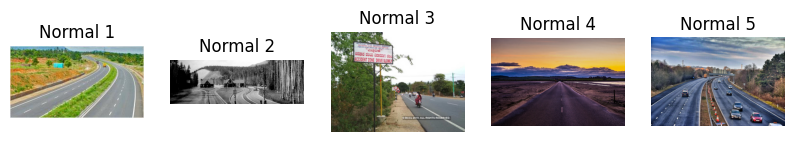

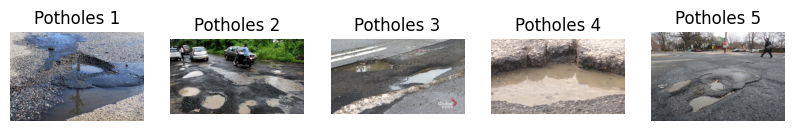

In [1]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Paths to dataset
normal_path = 'Dataset/normal'
potholes_path = 'Dataset/potholes'

# Function to display sample images
def show_samples(image_paths, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths[:5]):
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

# Show samples for both classes
normal_images = glob(os.path.join(normal_path, '*.jpg'))
potholes_images = glob(os.path.join(potholes_path, '*.jpg'))

show_samples(normal_images, 'Normal')
show_samples(potholes_images, 'Potholes')

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
import warnings
warnings.filterwarnings('ignore')

PREPROCESSING IMAGE SIZE

In [5]:
IMG_SIZE = (128, 128)

def preprocess_image(img):
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalization
    return img

LOAD AND PREPROCESS IMAGES

In [6]:
def load_and_preprocess_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = preprocess_image(img)  # Preprocess the image
            images.append(img)
            labels.append(label)
    return images, labels

normal_images, normal_labels = load_and_preprocess_images('Dataset/normal', 0)
potholes_images, potholes_labels = load_and_preprocess_images('Dataset/potholes', 1)

Convert to NumPY arrays

In [7]:
X = np.array(normal_images + potholes_images)
y = np.array(normal_labels + potholes_labels)

In [8]:
X_processed = np.array([preprocess_image(img) for img in X])

TRAIN TEST SPLIT

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

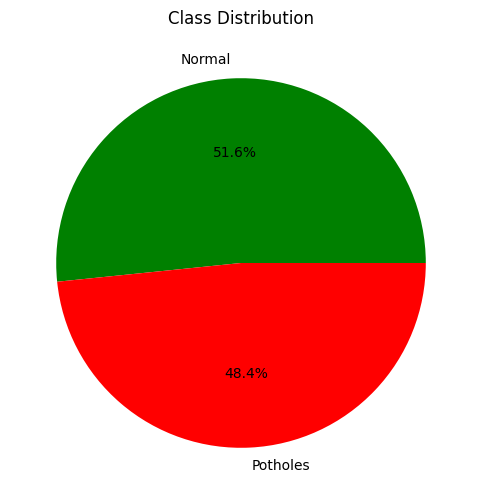

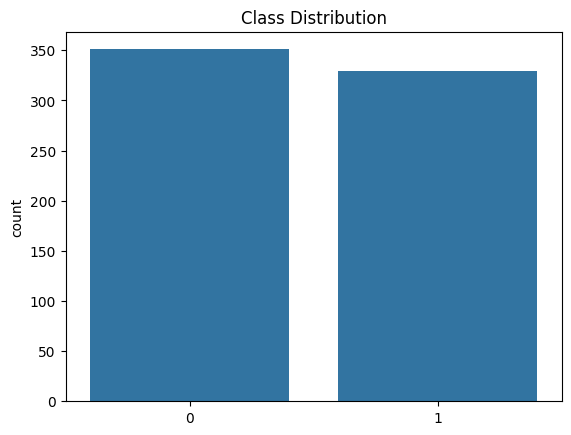

In [10]:
# Pie chart for class distribution
plt.figure(figsize=(6, 6))
plt.pie([np.sum(y == 0), np.sum(y == 1)], labels=['Normal', 'Potholes'], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Class Distribution')
plt.show()

# Bar plot for class distribution
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()

TRANSFER LEARNING

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Paths
normal_path = 'Dataset/normal'
potholes_path = 'Dataset/potholes'

In [15]:
# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory('Dataset/',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='binary',
                                        subset='training')

val_gen = datagen.flow_from_directory('Dataset/',
                                      target_size=(224, 224),
                                      batch_size=32,
                                      class_mode='binary',
                                      subset='validation')

Found 546 images belonging to 2 classes.
Found 135 images belonging to 2 classes.


In [16]:
models = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

87910968/87910968 [==============================] - 6s 0us/step


In [17]:
def build_model(base_model):
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Training VGG16
Epoch 1/10
18/18 [==============================] - 23s 666ms/step - loss: 0.5969 - accuracy: 0.6612 - val_loss: 0.4654 - val_accuracy: 0.8074
Epoch 2/10
18/18 [==============================] - 8s 424ms/step - loss: 0.4550 - accuracy: 0.8004 - val_loss: 0.3227 - val_accuracy: 0.9259
Epoch 3/10
18/18 [==============================] - 8s 423ms/step - loss: 0.3443 - accuracy: 0.8864 - val_loss: 0.2670 - val_accuracy: 0.9333
Epoch 4/10
18/18 [==============================] - 8s 423ms/step - loss: 0.2716 - accuracy: 0.9194 - val_loss: 0.2227 - val_accuracy: 0.9481
Epoch 5/10
18/18 [==============================] - 8s 416ms/step - loss: 0.2433 - accuracy: 0.9359 - val_loss: 0.1911 - val_accuracy: 0.9556
Epoch 6/10
18/18 [==============================] - 8s 429ms/step - loss: 0.2197 - accuracy: 0.9341 - val_loss: 0.1697 - val_accuracy: 0.9630
Epoch 7/10
18/18 [==============================] - 8s 417ms/step - loss: 0.2020 - accuracy: 0.9359 - val_loss: 0.1501 - val_accurac

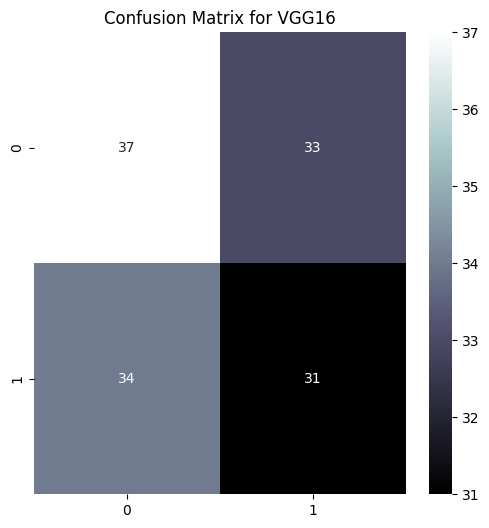

Classification Report for VGG16:
              precision    recall  f1-score   support

      normal       0.52      0.53      0.52        70
    potholes       0.48      0.48      0.48        65

    accuracy                           0.50       135
   macro avg       0.50      0.50      0.50       135
weighted avg       0.50      0.50      0.50       135

Accuracy: 97.78%



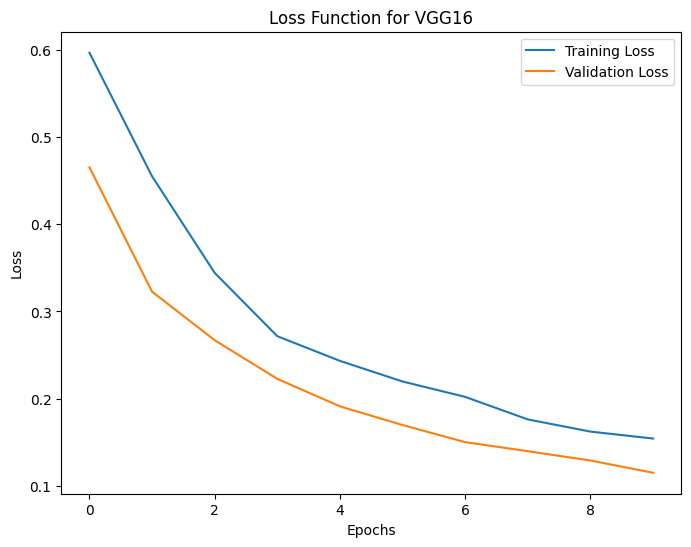

Training InceptionV3
Epoch 1/10
18/18 [==============================] - 16s 596ms/step - loss: 0.4590 - accuracy: 0.8077 - val_loss: 0.2337 - val_accuracy: 0.8963
Epoch 2/10
18/18 [==============================] - 7s 390ms/step - loss: 0.1893 - accuracy: 0.9249 - val_loss: 0.1173 - val_accuracy: 0.9704
Epoch 3/10
18/18 [==============================] - 7s 390ms/step - loss: 0.1251 - accuracy: 0.9560 - val_loss: 0.1014 - val_accuracy: 0.9704
Epoch 4/10
18/18 [==============================] - 7s 376ms/step - loss: 0.0738 - accuracy: 0.9762 - val_loss: 0.0883 - val_accuracy: 0.9704
Epoch 5/10
18/18 [==============================] - 7s 385ms/step - loss: 0.0573 - accuracy: 0.9835 - val_loss: 0.1094 - val_accuracy: 0.9630
Epoch 6/10
18/18 [==============================] - 7s 367ms/step - loss: 0.0365 - accuracy: 0.9908 - val_loss: 0.0970 - val_accuracy: 0.9556
Epoch 7/10
18/18 [==============================] - 7s 377ms/step - loss: 0.0489 - accuracy: 0.9835 - val_loss: 0.1263 - val_a

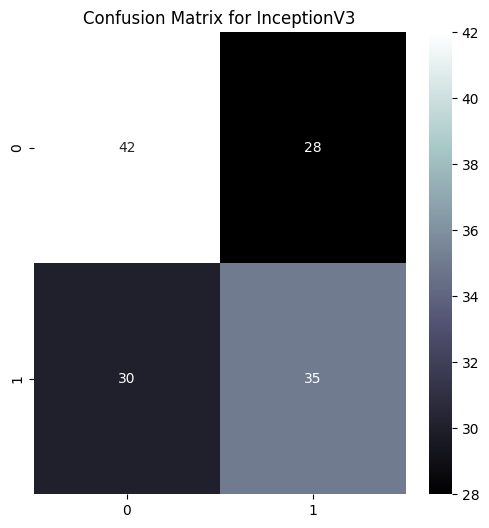

Classification Report for InceptionV3:
              precision    recall  f1-score   support

      normal       0.58      0.60      0.59        70
    potholes       0.56      0.54      0.55        65

    accuracy                           0.57       135
   macro avg       0.57      0.57      0.57       135
weighted avg       0.57      0.57      0.57       135

Accuracy: 95.56%



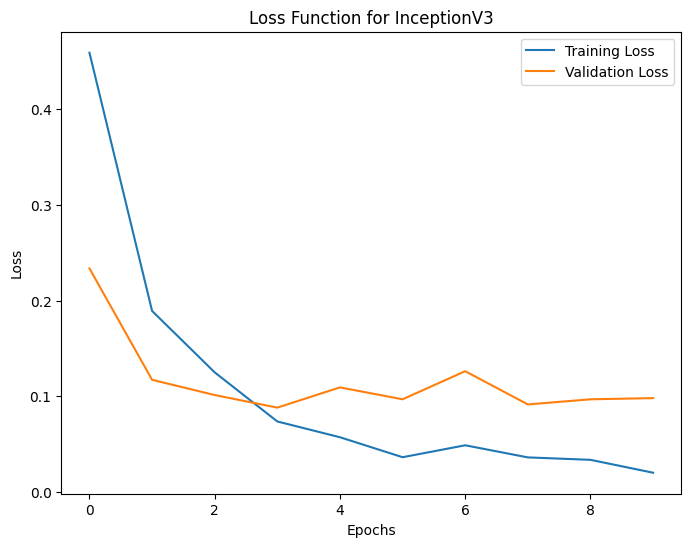

In [18]:
# Train, evaluate and collect results
results = {}
for name, base_model in models.items():
    print(f"Training {name}")
    model = build_model(base_model)
    
    # Train the model
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)
    
    # Evaluate on validation set
    val_pred = model.predict(val_gen)
    val_pred_labels = (val_pred > 0.5).astype(int)
    y_true = val_gen.classes
    
    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_true, val_pred_labels)
    cr = classification_report(y_true, val_pred_labels, target_names=val_gen.class_indices.keys())
    
    # Store results
    results[name] = {
        'accuracy': history.history['val_accuracy'][-1],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'confusion_matrix': cm,
        'classification_report': cr
    }
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='bone')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Print classification report
    print(f"Classification Report for {name}:\n{cr}")
    print(f"Accuracy: {results[name]['accuracy'] * 100:.2f}%\n")

    # Plot Loss Function Graphs
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Function for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

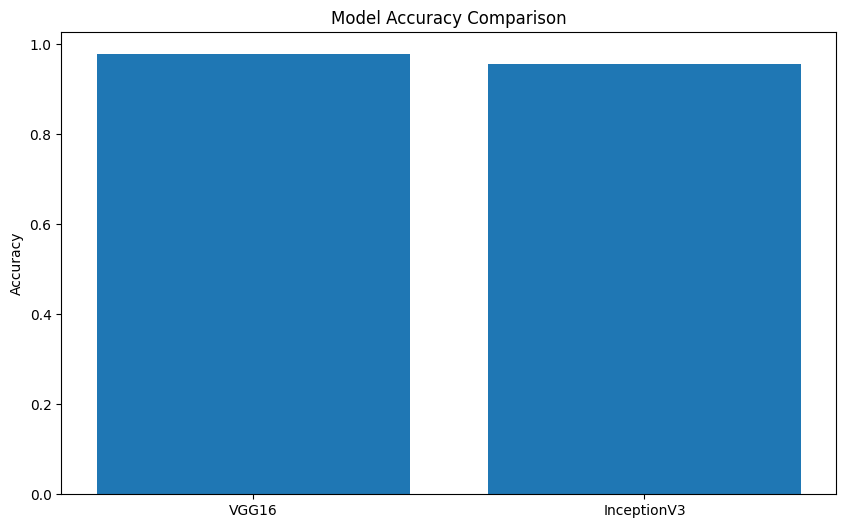

In [19]:
# Compare models' accuracy
accuracies = [results[model]['accuracy'] for model in models]
plt.figure(figsize=(10,6))
plt.bar(models.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

A Custom Compact Convolutional Transformer (CCT)

Steps to Implement Compact Convolutional Transformer (CCT)

Load and preprocess the dataset.

Build the CCT model.

Train the model.

Evaluate using the confusion matrix and classification report.

Plot the loss and accuracy graphs.

Found 546 images belonging to 2 classes.
Found 135 images belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                             

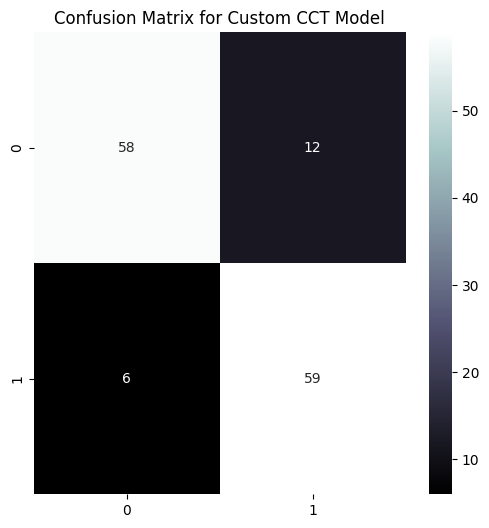

Classification Report for Custom CCT Model:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        70
           1       0.83      0.91      0.87        65

    accuracy                           0.87       135
   macro avg       0.87      0.87      0.87       135
weighted avg       0.87      0.87      0.87       135



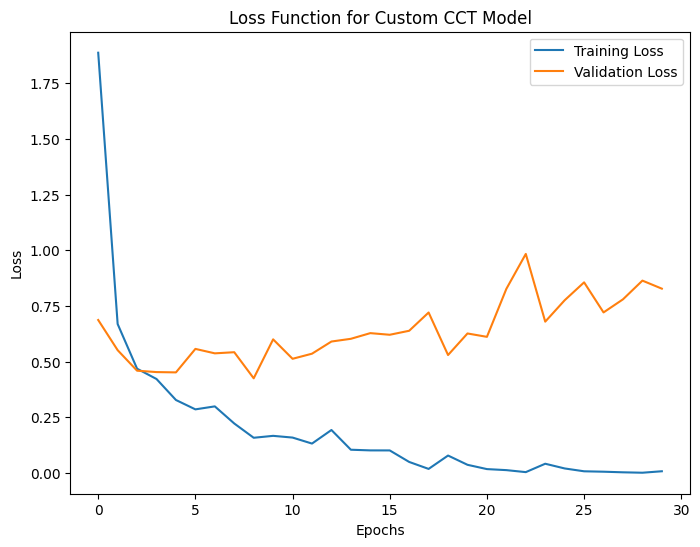

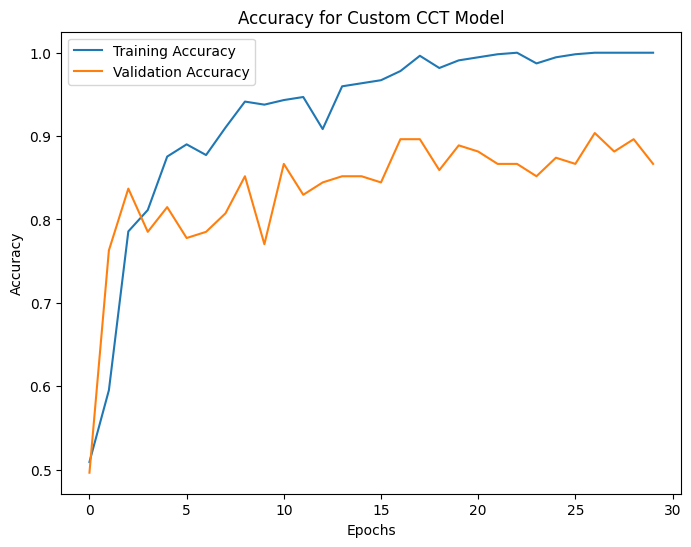

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
normal_path = 'Dataset/normal'
potholes_path = 'Dataset/potholes'

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory('Dataset/',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='binary',
                                        subset='training',
                                        shuffle=True)

val_gen = datagen.flow_from_directory('Dataset/',
                                      target_size=(224, 224),
                                      batch_size=32,
                                      class_mode='binary',
                                      subset='validation',
                                      shuffle=False)

# Define a custom CCT model using Keras
def create_custom_cct_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    # Convolutional layers to extract local features
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    # Flatten and dense layers for classification
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and compile the CCT model
custom_cct_model = create_custom_cct_model()

# Model summary
custom_cct_model.summary()

# Train the model
history = custom_cct_model.fit(train_gen, validation_data=val_gen, epochs=30)

# Predictions
val_pred = custom_cct_model.predict(val_gen)
val_pred_labels = (val_pred > 0.5).astype(int)
y_true = val_gen.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, val_pred_labels)
cr = classification_report(y_true, val_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='bone')
plt.title('Confusion Matrix for Custom CCT Model')
plt.show()

# Print classification report
print(f"Classification Report for Custom CCT Model:\n{cr}")

# Plot Loss Function Graph
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function for Custom CCT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy Graph
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy for Custom CCT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [2]:
custom_cct_model.save("cct_model_trained.h5")